# SNLE & SNRE
## Alternative ML Tools to Simulation Based Inference


- Brief refresher on key concepts
- SNLE
    - Getting the posterior through Bayes' rule
    - Why learn likelihoods?
    - Likelihood learning demo
    - Sampling via MCMC
- SNRE
- Learning likelihoods vs. posteriors?
- Further reading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
from mdn import MultivariateGaussianMDN, mog_log_prob, mog_sample

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor, ones, zeros, eye
from scipy.signal import argrelextrema
#from sbi.analysis import pairplot
#from sbi.utils import BoxUniform
#from torch.distributions import Normalcon
#import sdeint
_ = torch.manual_seed(0)

In [7]:
from numpy import *
from scipy import integrate

# Refresher: Prior, Joint, Likelihood and Posteior

<img src="./figures/2_2_snpe/simple_joint_all.png" alt="drawing" width="1500"/>

Simulator parameters have prior distribution $p(\theta)$.

For any *fixed* parameters $\theta$, observations are distributed according to the likelihood function $p(x|\theta)$. This is a well-normalized probability density in $x$, but not in $\theta$.

Together, simulator parameters $\theta$ and observations $x$ follow the joint density $p(\theta, x) = p(\theta)p(x|\theta)$.

For fixed observations $x_o$, we want the *posterior distribution* $p(\theta | x_o)$

## SNPE works by mapping any observations $x$ directly to a posterior $p(\theta | x)$

For example, we previously used a mixture density network to map from observations to the means, variances and weights of a Gaussian mixture:

` weights_of_gaussians, means, variances = mdn.get_mixture_components(x)`


## But we can also get the posterior through the likelihood, by applying Bayes' rule 

$$ p(\theta | x) = \frac{p(x | \theta) p(\theta)}{p(x)}$$

We already know the prior $p(\theta)$, so if we can calculate the likelihood $p(x | \theta)$, we can evaluate $p(\theta | x)$.


Caveat: we end up with a *scaled* version of $p(\theta | x)$, with scaling factor $1 / p(x)$. But for fixed observations $x_o$ this scaling factor doesn't depend on $\theta$.

Later on, we will discuss how to obtain samples from the scaled posterior.

SBI using neural density estimators to learn likelihoods instead of posteriors is called (**S**equential) **N**eural **L**ikelihood **E**stimation or (S)NLE
<img src="./figures/2_3_snle_snre/snle_paper.png" alt="drawing" width="400"/>

Just like SNPE, SNLE reduces Simulation Based Inference / Likelihood Free Inference to a conditional density estimation problem, and uses neural density estimation to solve that problem.

As before the training data are pairs $(\theta_j, x_j)$ where parameters $\theta_j$ were used for the simulation that generated observations $x_j$.

But while SNPE learns the conditional distribution $\theta|x$, SNLE learns $x|\theta$ 


# Why SNLE?
## We want the posterior $p(x|\theta)$, so why learn the mapping $\theta \rightarrow p(x|\theta)$ instead of $x \rightarrow p(\theta | x)$?



## Likelihood learning two clear advantages:

1. When $\theta$ is not prior-sampled, SNPE requires correction since the posterior changes. But SNLE works out of the box on any $(\theta, x)$ simulation pairs since the likelihood doesn't change. We can sample $\theta$ from any distribution, or pick it with any algoirthm.

2. With several statistically independent observations $x_i$, $p(x|\theta)=\prod_i p(x_i | \theta)$. Therefore we can learn the conditional distribution for just one observation. In contrast, learning $p(\theta | x)$ requires the network to take all observations as input at once, a more difficult learning task.

But SNLE also has disadvantages, and each problem could favor SNPE or SNLE. We'll return to this later with a full comparison.

## Now let's solve an SBI problem with SNLE!

### Simulator: 1D sinusoid + linear trend + noise
$$x = 2\theta + \sin(6\theta) + \varepsilon \\
\varepsilon \sim \mathcal{N}(0, 0.3^2)$$

### Prior: Uniform on $(0, 1)$

### Observations: $x_o = 1$

In [27]:
def simulator(theta):
    return theta*2.0 + torch.sin(theta*6) + torch.randn(theta.shape) * 0.3

theta = torch.rand(10000)  # Uniform on (0, 1)
x = simulator(theta)

x_o = torch.ones(1,1, dtype=torch.float32)

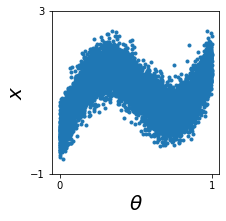

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.plot(theta.detach().numpy(), x.detach().numpy(), '.')

ax.set_xticks([0, 1])
ax.set_yticks([-1, 3.0])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
#ax.set_title(r"Training data", fontsize=20)
plt.savefig("figures/2_3_snle_snre/scatter.png", dpi=200, bbox_inches="tight")

### Training data: simulations with prior-samples $\theta$

<img src="./figures/2_3_snle_snre/scatter.png" alt="drawing" width="300"/>

## Learning the likelihood $p(x | \theta)$

We use a mixture density network as for SNPE, but now the roles of $x$ and $\theta$ are switched.

In [12]:
_ = torch.manual_seed(0)

In [64]:
dataset = data.TensorDataset(x.reshape(-1, 1), theta.reshape(-1, 1))
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
    ),
    num_components=1,
    hidden_features=10,
)

In [65]:
opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(100):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        weights_of_gaussians, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, weights_of_gaussians, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

## Now let's test our likelihood estimate for several values of $\theta$

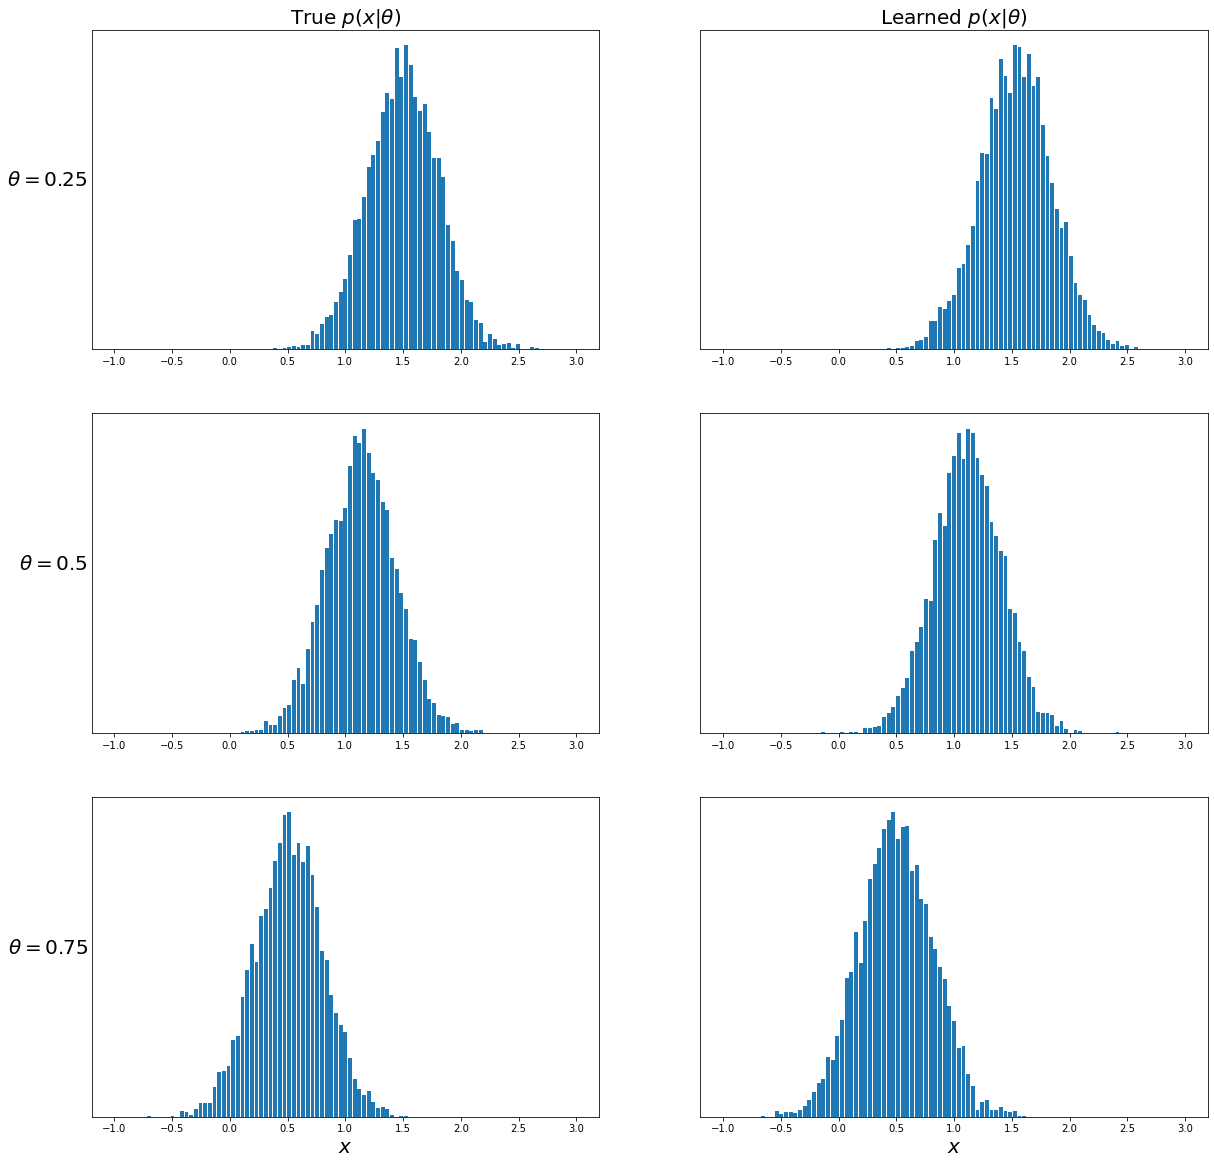

In [117]:
n = 5000
theta_test = [0.25, 0.5, 0.75]

bin_edges = np.linspace(-1, 3, 100)
bin_width = np.diff(bin_edges[:2])
bin_centers = bin_edges[:-1] + bin_width / 2

plt.figure(figsize=(20, 20))

for k, th in enumerate(theta_test):
    # simulate
    theta_vals = torch.ones(n) * th
    x_vals = simulator(theta_vals).detach().numpy().reshape(-1)
    
    w, means, variances = mdn.get_mixture_components(torch.ones(1,1,) * th)  # get likelihood estimate
    # sample x|\theta based on the likelihood
    samples = [mog_sample(w, means, variances) for _ in range(n)]
    samples = torch.cat(samples, axis=0).detach().numpy().reshape(-1)
    
        
    ax = plt.subplot(len(theta_test), 2, 1 + 2 * k)
    plt.bar(bin_centers, np.histogram(x_vals, bin_edges)[0], width = bin_width * 0.8)
    ax.set_ylabel(f"$\\theta = {th}$", fontsize=20., rotation=0, horizontalalignment='right')    
    ax.set_yticks([])
    if k == len(theta_test) - 1:
        ax.set_xlabel(r"$x$", fontsize=20.)
    if k == 0:
        ax.set_title(r"True $p(x|\theta)$", fontsize=20.)
        
    ax = plt.subplot(len(theta_test), 2, 2 + 2 * k)
    plt.bar(bin_centers, np.histogram(samples, bin_edges)[0], width = bin_width * 0.8)
    if k == len(theta_test) - 1:
        ax.set_xlabel(r"$x$", fontsize=20.)
    ax.set_yticks([])
   
    if k == 0:
        ax.set_title(r"Learned $p(x|\theta)$", fontsize=20.)
    if k == len(theta_test) - 1:
        ax.set_xlabel(r"$x$", fontsize=20.)
        
plt.savefig("figures/2_3_snle_snre/hists.png", dpi=200, bbox_inches="tight")

<img src="./figures/2_3_snle_snre/hists.png" alt="drawing" width="600"/>    
   
## Our MDN has learned the mapping $\theta \rightarrow p(x|\theta)$

### Our MDN has now learned to calculate $p(x | \theta)$ for any $x$ and $\theta$.

### We also know $p(\theta)$.

### But how can we sample from $p(\theta |x) = \frac{p(x | \theta) p(\theta)}{p(x)}$?

We can evaluate the $p(\theta |x)$ up to an unknown constant scaling factor. How can we use this to generate samples?

We use **Markov Chain Monte Carlo**, a general technique for sampling from a density we can evaluate up to an unknown constant scaling factor.

Basic idea: start with any $\theta$, and randomly transform it according to $\theta \rightarrow \mathcal T(\theta)$

The trick is to set up the random transformation $\mathcal T$ to map $p(\theta|x_o)$ onto itself: when $\theta\sim p(\theta|x_o)$ we should also have $\mathcal T(\theta) \sim p(\theta|x_o)$. Then we  repeatedly apply $\mathcal T$ to generate independent samples from $p(\theta|x_o)$. 

One way of doing this is using the Metropolis Hasting algorithm. We use a particularly simple form of this method as follows:

$$ \theta^\prime = \theta + z \\
z \sim \mathcal N(0, 0.25^2) \\
a = \min\left(1, \frac{p(\theta^\prime|x_o)}{p(\theta|x_o)}\right) \\
\mathcal T(\theta) = \begin{cases}
\theta^\prime\quad\quad\quad\text{with probability } a \\
\theta\quad\quad\quad\text{with probability } 1-a
\end{cases} $$

Because the posterior appears in the numerator and denominator of $a$, the unknown scaling factor cancels out and we can calculate $a$:

$$\frac{p(\theta^\prime|x_o)}{p(\theta|x_o)} = 
\frac{p(x_o|\theta^\prime) p(\theta^\prime)/p(x_o)}{p(x_o|\theta)p(\theta)/p(x_o)} = \frac{p(x_o|\theta^\prime) p(\theta^\prime)}{p(x_o|\theta)p(\theta)}$$

## Let's try it!

In [268]:
n = 100000  # MCMC steps

def likelihood(theta, x):
    w, means, variances = mdn.get_mixture_components(theta)
    return torch.exp(mog_log_prob(x, w, means, variances)).detach().numpy()[0]
    
# start at the middle of the prior. doesn't matter where, as long as the prior is nonzero here
theta = torch.zeros(1, 1) + 0.5

likelihood_theta = likelihood(theta, x_o)
prior_theta = 1.  # uniform prior on (0, 1)

theta_samples = []
for i in range(n):
    thetaprime = theta + 0.25 * torch.randn(1, 1)  # random perturbation
    
    likelihood_thetaprime = likelihood(thetaprime, x_o)
    
    # uniform prior on (0, 1)
    if thetaprime < 0 or thetaprime > 1:
        prior_thetaprime = 0.
    else:
        prior_thetaprime = 1.

    a = np.minimum(1.0, (likelihood_thetaprime * prior_thetaprime) / (likelihood_theta * prior_theta))
    if np.random.rand() < a:
        theta, likelihood_theta, prior_theta = thetaprime, likelihood_thetaprime, prior_thetaprime
        
    
    theta_samples.append(theta.detach().numpy()[0,0])

theta_samples = np.array(theta_samples)

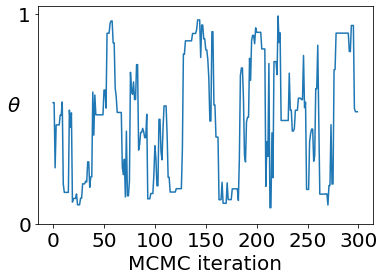

In [269]:
plt.plot(theta_samples[:300])
plt.gca().set_yticks([0, 1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('MCMC iteration', fontsize=20)
plt.ylabel('$\\theta$', fontsize=20, rotation=0)
plt.savefig("./figures/2_3_snle_snre/mcmc_samples.png", dpi=200, bbox_inches="tight")

### Now we have samples from $p(\theta|x_o)$

<img src="./figures/2_3_snle_snre/mcmc_samples.png" alt="drawing" width="250"/>    

But each $\theta$ depends on the previous one, so the samples are correlated. Let's measure this:

In [270]:
kmax = 30
cc = [np.corrcoef(theta_samples[:-k], theta_samples[k:])[0,1] for k in range(1, kmax)]

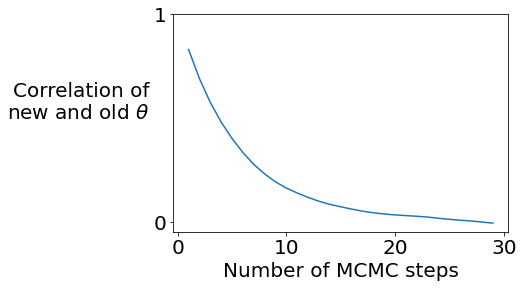

In [271]:
plt.plot(np.arange(1, kmax), cc)
plt.gca().set_yticks([0, 1])
plt.xticks(fontsize=20)
plt.gca().set_xticks(np.arange(0, kmax+1, 10))
plt.yticks(fontsize=20)
plt.xlabel('Number of MCMC steps', fontsize=20)
plt.ylabel('Correlation of\nnew and old $\\theta$', fontsize=20, rotation=0, horizontalalignment='right')
plt.savefig("./figures/2_3_snle_snre/mcmc_corr.png", dpi=200, bbox_inches="tight")

<img src="./figures/2_3_snle_snre/mcmc_corr.png" alt="drawing" width="300"/>

To obtain independent posterior samples, we keep every 30-th MCMC step.

In [272]:
theta_samples_decimated = theta_samples[::30]

bin_edges = np.linspace(0, 1, 101)
bin_width = np.diff(bin_centers[:2])
bin_centers = bin_edges[:-1] + bin_width / 2

theta_hist = np.histogram(theta_samples_decimated, bin_edges)[0]

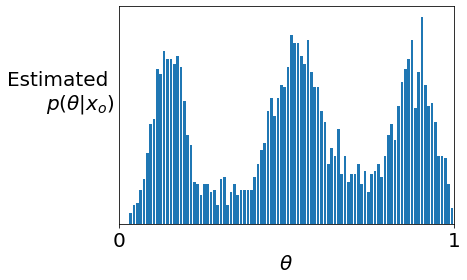

In [283]:
plt.bar(bin_centers, theta_hist, width = bin_width * 0.8)
plt.xlim(0, 1)
plt.gca().set_xticks([0, 1])
plt.xticks(fontsize=20)
plt.gca().set_yticks([])
plt.ylabel('Estimated \n$p(\\theta | x_o)$', rotation=0, fontsize=20, horizontalalignment='right')
plt.xlabel(r'$\theta$', fontsize=20)
plt.savefig("./figures/2_3_snle_snre/mcmc_posterior.png", dpi=200, bbox_inches="tight")

### Finally, we use the remaining samples as our posterior

<img src="./figures/2_3_snle_snre/mcmc_posterior.png" alt="drawing" width="300"/>

For this simple 1D problem, we can compare to a 'brute force' calculation:

<img src="./figures/2_2_snpe/simple_joint.png" alt="drawing" width="300"/>

### Sequential Neural Ratio Estimation (SNRE)

<img src="./figures/2_3_snle_snre/snre_paper.png" alt="drawing" width="300"/>

Instead of training a neural density estimator for $p(\theta|x)$ or $p(x|\theta)$, we train a *classifier* to distinguish between samples from $p(x, \theta)$ and $p(x)p(\theta)$.

If for a pair of inputs $(x, \theta)$, the trained classifier assign the probability $d$ that $x$ was simulated by $\theta$, and not other random parameters from the prior, we can calculate

$$ d / (1 - d) = p(x|\theta) / p(x)$$

This is the same likelihood that we learned with SNLE, only now we have the normalization constant as well. We can use this to perform MCMC sampling as we did for SNLE.

The advantage here is that training a classifier is usually easier than training a neural density estimator.

However, a potential difficulty is that $d$ might be close to zero or one for many training pairs $(x, \theta)$, which can cause difficulties during trianing.

### Comparing Our Three Methods
**SNPE**

**+** Fast amortized inference

**-** Requires special corrections if $\theta$ is not prior-sampled in the training data.

**SNLE**

**+** Likelihood factorizes for i.i.d. observations

**+** Can generate training data with $\theta$ from any distribution or algorithm

**-** For high-dimensional observations, learning $p(x|\theta)$ can be very challenging

**-** Requires MCMC

**SNRE**

**+** Likelihood factorizes for i.i.d. observations

**+** Training a classifier can be easier than training a NDE

**-** $\theta$ must be prior-sampled for training

**-** Possible numerical issues when $d$ is close to zero or 1

**-** Requires MCMC



## Problem-specific considerations

### When should we try to learn $p(\theta|x)$ directly, and when should we learn $p(x|\theta)$ and use MCMC?

- Consider the dimensions of both $x$ and $\theta$. Learning neural density estimators in high-dimensional spaces is challenging, but neural nets can take high dimesional input without much difficulty. So we can use SNPE when $\dim(x) >> \dim(\theta)$, and SNLE/SNRE when $\dim(x) << \dim(\theta)$
- We can also make use of **structure** in $x$ or $\theta$. When one of these is an image (or time series), we could use a CNN (RNN) to process it as output. For learning distributions on $x$ or $\theta$, we can also use neural density estimators designed for these objects. Additional forms of structure (graphs, sets, etc.) can also be exploited.
- The feasibility of MCMC depends on the nature of the $\theta$ space, and its dimension.
- For high dimensional parameter spaces and expensive simulations, multi-round methods (where an initial posterior estimate is used to guide further simulations) seem to give a larger advantage. But SNPE might have issues when the prior has sharp boundaries, and repeated MCMC could end up more computationally expensive the the neural network training itself.
- All of these considerations are active areas of research, and the set of SBI/LFI problems for which these methods have been tested remains small!

## Further reading

**SNL** Papamakarios, Sterratt & Murray. "Sequential neural likelihood: Fast likelihood-free inference with autoregressive flows." AISTATS, 2019.

**MCMC** Svensén & Bishop. "Pattern recognition and machine learning." 2007.

**SNRE** Hermans, Begy & Louppe. "Likelihood-free mcmc with amortized approximate ratio estimators." ICML, 2020.

Durkan, Murray & Papamakarios. "On contrastive learning for likelihood-free inference." ICML, 2020.

**Benchmarks** Durkan, George Papamakarios & Murray. "Sequential neural methods for likelihood-free inference." arXiv, 2018.

Lueckmann et al. "Benchmarking Simulation-Based Inference." AISTATS, 2021.

**..and beyond!** Brehmer, Johann, et al. "Mining gold from implicit models to improve likelihood-free inference." PNAS, 2020.

Cranmer, Kyle, Johann Brehmer, and Gilles Louppe. "The frontier of simulation-based inference." PNAS, 2020.